# jsPCA Multislice Tutorial

This notebook demonstrates how to apply jsPCA to multiple spatial transcriptomics slices or samples stored in `.h5ad` format.

Input data: `data/DLPFC/*.h5ad`  
Output results: `results/Multislice/`  
Evaluation metrics: ARI, NMI, runtime, memory  

It includes:

- Loading `.h5ad` files.
- Preprocessing spatial transcriptomics data for each slice.
- Computing adjacency matrices using the mutual k-nearest neighbor (KNN).
- Performing jsSPCA across multiple slices.
- Clustering with Gaussian Mixture Models (GMM).
- Spatial refinement using SpaGCN.
- Evaluating performance (ARI, NMI).
- Saving results.

This notebook assumes you have a folder `data/DLPFC` with `.h5ad` files and the required utility scripts in `utils/`.

## Imports and setup

In [63]:
# ===============================
# Import Libraries
# ===============================

# -------------------------------
# System libraries
# -------------------------------
import os        # For path manipulations
import sys       # To modify Python path 
import glob      # For finding files with patterns
import warnings  # To suppress unnecessary warning messages

# -------------------------------
# Data handling
# -------------------------------
import numpy as np       # Numerical computations
import pandas as pd      # Dataframes for tabular data

# -------------------------------
# Single-cell / spatial transcriptomics
# -------------------------------
import anndata as ad     # AnnData object format for single-cell data
import scanpy as sc      # Preprocessing, normalization, scaling, and general scRNA-seq analysis
import SpaGCN as spg     # Spatial graph convolutional network for spatial cluster refinement

# -------------------------------
# Visualization
# -------------------------------
import matplotlib.pyplot as plt   # Plotting library for creating static, interactive, and animated visualizations

# -------------------------------
# Sparse matrices
# -------------------------------
from scipy.sparse import csr_matrix   # Efficient storage and manipulation of sparse matrices

# -------------------------------
# Clustering evaluation metrics
# -------------------------------
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score  # Cluster comparison metrics

# -------------------------------
# Add 'utils/' folder to Python path
# -------------------------------
# Use the absolute path to your 'utils' folder 
utils_path = r"C:\Users\assali.i\Desktop\jspca-project\utils"
if utils_path not in sys.path:
    sys.path.append(utils_path)
print("✅ utils folder added to Python path:", utils_path)

# -------------------------------
# Project-specific utility functions
# -------------------------------
from projection_utils_sparse import project_components
from hungarian_algorithm import apply_hungarian_algorithm
from eigen_utils import compute_sorted_eigen
from clustering_utils import perform_gmm_clustering
from jspca_utils import joint_spca
from spca_utils import compute_spca
from adjacency_matrix_knn import compute_mutual_knn_matrices

# -------------------------------
# Suppress warnings to keep notebook output clean
# -------------------------------
warnings.filterwarnings("ignore")

print("✅ All libraries imported successfully.")


✅ utils folder added to Python path: C:\Users\assali.i\Desktop\jspca-project\utils
✅ All libraries imported successfully.


## Define input and output folders

In [64]:
# ===============================
# Define file paths
# ===============================

import os
import glob

# Base directory: folder where the project is located
# For notebook: use os.getcwd(); for script: use os.path.dirname(os.path.abspath(__file__))
try:
    base_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    base_dir = os.getcwd()  # fallback if running in a notebook

# Input folder containing spatial transcriptomics .h5ad files
folder_path = os.path.join(base_dir, "..", "data", "DLPFC")  # ".." goes up one folder to reach the correct path

# Output folder to save results
output_folder = os.path.join(base_dir, "..", "results", "Multislice")
os.makedirs(output_folder, exist_ok=True)  # Create folder if it doesn't exist

# List all .h5ad files in the input folder 
file_list = sorted([f for f in glob.glob(os.path.join(folder_path, "*")) if f.lower().endswith(".h5ad")])

# Display file information
if not file_list:
    print("⚠️ No .h5ad files found in:", folder_path)
else:
    print(f"📂 Found {len(file_list)} files to process:")
    for f in file_list:
        print("  •", os.path.basename(f))

📂 Found 2 files to process:
  • 151673.h5ad
  • 151674.h5ad


## Preprocessing of `.h5ad` datasets

In this section, we perform two main tasks:

1. Load all `.h5ad` files from the input folder. Only datasets containing a `ground_truth` column in `adata.obs` are kept. Datasets missing this column are skipped.
2. Preprocess each dataset by:
   - Selecting only genes that are common across all datasets
   - Normalizing counts using Pearson residuals
   - Scaling the expression values to zero mean and unit variance

In [65]:
# -------------------------------
# Step 1️⃣ – List available input files
# -------------------------------
# Find all .h5ad files in the input folder 
file_list = sorted([f for f in glob.glob(os.path.join(folder_path, "*")) if f.lower().endswith(".h5ad")])

# Display found files
if not file_list:
    raise RuntimeError(f"⚠️ No .h5ad files found in {folder_path}")
else:
    print(f"📂 Found {len(file_list)} files to process:")
    for f in file_list:
        print("  •", os.path.basename(f))

# -------------------------------
# Step 2️⃣ – Load datasets
# -------------------------------
file_paths = file_list  # reuse the list above

# Initialize empty lists to store loaded data
adatas = []
valid_sample_ids = []

for path in file_paths:
    try:
        adata = sc.read_h5ad(path)
        if 'ground_truth' not in adata.obs:
            print(f"Skipping {path}: 'ground_truth' column missing")
            continue
        # Remove cells with missing ground truth
        adata = adata[~adata.obs['ground_truth'].isna()].copy()
        # Filter out genes expressed in fewer than 20 cells
        sc.pp.filter_genes(adata, min_cells=20)
        adatas.append(adata)
        valid_sample_ids.append(os.path.splitext(os.path.basename(path))[0])
    except Exception as e:
        print(f"❌ Failed to load {path}: {e}")

if len(adatas) < 2:
    raise ValueError("At least 2 valid datasets are required for joint analysis.")
print(f"✅ Successfully loaded {len(adatas)} datasets.")


# Identify genes that are common across all datasets
common_genes = set(adatas[0].var_names)
for ad in adatas[1:]:
    common_genes &= set(ad.var_names)
common_genes = list(common_genes)

# Normalize and scale each dataset
for i in range(len(adatas)):
    adatas[i] = adatas[i][:, common_genes].copy()
    sc.experimental.pp.normalize_pearson_residuals(adatas[i])
    sc.pp.scale(adatas[i])
    
print(f"✅ Preprocessing complete — all datasets share {len(common_genes)} common genes.")

# the maximum number of clusters across all datasets.
num_labels = [len(ad.obs['ground_truth'].unique()) for ad in adatas]
max_labels = max(num_labels)
print(f"Maximum number of ground truth clusters: {max_labels}")

# Store expression matrices for later use
X_sparse = [ad.X for ad in adatas]

📂 Found 2 files to process:
  • 151673.h5ad
  • 151674.h5ad
✅ Successfully loaded 2 datasets.
✅ Preprocessing complete — all datasets share 15026 common genes.
Maximum number of ground truth clusters: 7


## Compute adjacency matrices

For each dataset, we compute the **adjacency matrix**, which captures neighborhood relationships using the mutual k-nearest neighbor (KNN) method.  

In [66]:
print("📌 Computing KNN matrices...")
for i in range(len(adatas)):
    dist, conn = compute_mutual_knn_matrices(adatas[i])
    adatas[i].obsp['distances'] = dist
    adatas[i].obsp['connectivities'] = csr_matrix(conn)

print("🔧 Computing SPCA matrices...")
A_spca = [compute_spca(ad) for ad in adatas]

📌 Computing KNN matrices...
Automatically selected k = 18
Mutual KNN graph construction successful!
Automatically selected k = 18
Mutual KNN graph construction successful!
🔧 Computing SPCA matrices...


## Spatial Refinement and Scoring Function

This function uses SpaGCN to refine GMM cluster assignments based on spatial adjacency and calculates ARI and NMI compared to ground truth.

In [67]:
def refine_and_score(adata, gmm_clusters):
    """
    Refine clusters using SpaGCN and compute ARI/NMI.
    """
    try:
        # Extract spatial coordinates
        if "x" in adata.obs and "y" in adata.obs:
            x_array, y_array = adata.obs["x"].tolist(), adata.obs["y"].tolist()
        elif "spatial" in adata.obsm:
            x_array, y_array = adata.obsm["spatial"][:, 0].tolist(), adata.obsm["spatial"][:, 1].tolist()
        else:
            raise ValueError("Missing spatial coordinates")
        
        # Compute adjacency matrix and refine clusters
        adj_2d = spg.calculate_adj_matrix(x=x_array, y=y_array, histology=False)
        refined_pred = spg.refine(adata.obs.index.tolist(), gmm_clusters, adj_2d, shape="square")
        
        # Store results in adata
        adata.obs["refined_pred"] = pd.Categorical(refined_pred)
        adata.obs["GMM_clusters"] = gmm_clusters
        
        # Compute ARI and NMI
        obs_df = adata.obs.dropna(subset=["refined_pred", "ground_truth"])
        if obs_df.empty:
            return refined_pred, 0, 0
        ari = adjusted_rand_score(obs_df["refined_pred"], obs_df["ground_truth"])
        nmi = normalized_mutual_info_score(obs_df["refined_pred"], obs_df["ground_truth"])
        return refined_pred, ari, nmi
    except Exception as e:
        print(f"⚠️ Refinement failed: {e}")
        return None, 0, 0

## Multi-slice jsPCA Analysis

For several values of k (k = 10, 20, 30, 40, 50, representing the number of jsPCA components), we:
 1. Perform jsPCA across all slices and extract the top `k` eigenvectors to reduce dimensionality while preserving key patterns.
 2. Project the original data onto these k components to obtain a lower-dimensional representation.
 3. Apply Gaussian Mixture Model (GMM) clustering.
 4. Refine clusters spatially using SpaGCN and evaluate clustering quality with ARI and NMI
 5. Select the k value that yields the highest average ARI/NMI, representing the most accurate and biologically meaningful clustering

In [68]:
best_score, best_k, best_outputs = -1, None, []

for k in [10, 20, 30, 40, 50]:
    try:
        # Perform jsPCA
        result = joint_spca(A_spca, k=k)
        optimized_matrix = result['optimized_matrix']
        projections = [project_components(X, np.real(optimized_matrix), k) for X in X_sparse]
        combined = np.vstack(projections)

        # GMM clustering
        gmm_clusters = perform_gmm_clustering(combined, max_labels, random_state=42)
        gmm_splits = np.split(gmm_clusters, np.cumsum([len(ad) for ad in adatas[:-1]]))

        score_list, output_list = [], []
        for i, ad in enumerate(adatas):
            refined_pred, ari, nmi = refine_and_score(ad, gmm_splits[i])
            ad.obs["GMM_clusters"] = gmm_splits[i]
            ad.obs["refined_pred"] = pd.Categorical(refined_pred)
            ad.uns.update({"ARI": ari, "NMI": nmi, "chosen_k": k})
            score_list.append((ari + nmi) / 2)
            output_list.append(ad.copy())

        avg_score = np.mean(score_list)

        if avg_score > best_score:
            best_score = avg_score
            best_k = k
            best_outputs = output_list

        print(f"✅ k={k} | Avg Score={avg_score:.4f}")
    except Exception as e:
        print(f"❌ jsPCA failed for k={k}: {e}")
        continue

print(f"\n🎯 Best k: {best_k} | Average score: {best_score:.4f}")

Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
  1          -6.0435867554518604e+11    6.92493550e+09    
  2          -6.0438115071622168e+11    3.86333449e+09    
  3          -6.0438480644539233e+11    2.99123109e+09    
  4          -6.0438754470057153e+11    2.72881004e+09    
  5          -6.0439022874167847e+11    2.24113376e+09    
  6          -6.0439285038979150e+11    2.69978692e+09    
  7          -6.0439295765932825e+11    5.08766029e+09    
  8          -6.0439337950872827e+11    4.91660884e+09    
  9          -6.0439494825774768e+11    4.23283794e+09    
 10          -6.0439911412093335e+11    1.86440755e+09    
 11          -6.0440008205819434e+11    7.86389517e+09    
 12          -6.0440368921862793e+11    6.79314195e+09    
 13          -6.0441327339910461e+11    2.51639407e+09    
 14          -6.0441364338431360e+11    4.90966614e+09    
 15          -6.0441503147894019e+11    4.

## Save Results

We save the refined `.h5ad` datasets, as well as ARI/NMI scores in an Excel file.
Each dataset stores the final clustering results and metrics.

In [69]:
# Save individual datasets
for i, ad in enumerate(best_outputs):
    out_path = os.path.join(output_folder, f"jsPCA_joint_{valid_sample_ids[i]}.h5ad")
    ad.write(out_path)
    print(f"📁 Saved: {out_path} | ARI: {ad.uns['ARI']:.4f}, NMI: {ad.uns['NMI']:.4f}")

# Save ARI/NMI metrics
ari_nmi_df = pd.DataFrame({
    "Sample_ID": valid_sample_ids,
    "ARI": [ad.uns["ARI"] for ad in best_outputs],
    "NMI": [ad.uns["NMI"] for ad in best_outputs]
})
ari_nmi_file = os.path.join(output_folder, "ari_nmi.xlsx")
ari_nmi_df.to_excel(ari_nmi_file, index=False)
print(f"\n📄 Saved ARI/NMI metrics to {ari_nmi_file}")

📁 Saved: C:\Users\assali.i\Desktop\jspca-project\tutorial\..\results\Multislice\jsPCA_joint_151673.h5ad | ARI: 0.5513, NMI: 0.6488
📁 Saved: C:\Users\assali.i\Desktop\jspca-project\tutorial\..\results\Multislice\jsPCA_joint_151674.h5ad | ARI: 0.5190, NMI: 0.6375

📄 Saved ARI/NMI metrics to C:\Users\assali.i\Desktop\jspca-project\tutorial\..\results\Multislice\ari_nmi.xlsx


## Visualization 

In this section, we visualize the final results obtained.
It is divided into two main parts:
 1. Alignment of predicted clusters with ground truth labels using the **Hungarian algorithm**
 2. Visualization of spatial cluster assignments

### Cluster Assignment with the Hungarian Algorithm

After performing joint jsPCA and spatial refinement, the cluster labels may not directly match the ground truth labels. To ensure consistent comparison, we use the Hungarian algorithm to find the optimal one-to-one mapping between predicted clusters and ground truth classes.

This step:
  1. Loads all joint jsPCA output files
  2. Aligns predicted clusters with ground truth using the Hungarian algorithm
  3. Saves aligned results to new `.h5ad` files

In [70]:
import anndata as ad
# -------------------------------
# Step 1️⃣ – Define input/output paths
# -------------------------------
input_folder = output_folder  # Folder containing jsPCA joint results
output_folder_hungarian = os.path.join(output_folder, "Hungarian_Matched")
os.makedirs(output_folder_hungarian, exist_ok=True)

# Find all jsPCA joint output files
input_paths = sorted([f for f in glob.glob(os.path.join(input_folder, "jsPCA_joint_*.h5ad"))])
output_paths = [os.path.join(output_folder_hungarian, os.path.basename(p).replace(".h5ad", "_matched.h5ad")) for p in input_paths]

print(f"📂 Found {len(input_paths)} files to align:")
for p in input_paths:
    print("  •", os.path.basename(p))

# -------------------------------
# Step 2️⃣ – Define alignment function
# -------------------------------
def align_labels_only(adata, dataset_name):
    """
    Apply Hungarian algorithm to align predicted clusters with ground truth.
    Reuse existing ARI/NMI metrics; do not recompute.
    """
    print(f"\n🔄 Applying Hungarian algorithm for {dataset_name}...")

    if "refined_pred" not in adata.obs or "ground_truth" not in adata.obs:
        print(f"⚠️ Missing required columns in {dataset_name}. Skipping...")
        return adata

    refined_pred = adata.obs["refined_pred"]
    ground_truth = adata.obs["ground_truth"]

    valid_idx = ~refined_pred.isna() & ~ground_truth.isna()
    refined_valid = refined_pred[valid_idx]
    gt_valid = ground_truth[valid_idx]

    if len(gt_valid) == 0:
        print(f"⚠️ No valid cells for {dataset_name}.")
        return adata

    # Apply Hungarian algorithm to align labels
    mapped_labels = apply_hungarian_algorithm(gt_valid, refined_valid)

    # Store aligned labels in a new column
    aligned_series = pd.Series(index=adata.obs_names, dtype="object")
    aligned_series.loc[valid_idx] = mapped_labels
    adata.obs["refined_pred_Hungarian"] = pd.Categorical(aligned_series)

    # **Do not recompute ARI/NMI**; reuse existing values
    ari = adata.uns.get('ARI', 0)
    nmi = adata.uns.get('NMI', 0)
    print(f"✅ {dataset_name} – ARI: {round(ari, 2)}, NMI: {round(nmi, 2)} ")

    return adata

# -------------------------------
# Step 3️⃣ – Apply alignment to all datasets
# -------------------------------
for input_path, output_path in zip(input_paths, output_paths):
    dataset_name = os.path.splitext(os.path.basename(input_path))[0]
    print(f"\n📂 Loading {dataset_name}...")
    
    adata = ad.read_h5ad(input_path)
    adata = align_labels_only(adata, dataset_name)
    
    adata.write(output_path)
    print(f"📦 Saved aligned dataset → {output_path}")

print("\n✅ All datasets aligned using the Hungarian algorithm !")


📂 Found 2 files to align:
  • jsPCA_joint_151673.h5ad
  • jsPCA_joint_151674.h5ad

📂 Loading jsPCA_joint_151673...

🔄 Applying Hungarian algorithm for jsPCA_joint_151673...
✅ jsPCA_joint_151673 – ARI: 0.55, NMI: 0.65 
📦 Saved aligned dataset → C:\Users\assali.i\Desktop\jspca-project\tutorial\..\results\Multislice\Hungarian_Matched\jsPCA_joint_151673_matched.h5ad

📂 Loading jsPCA_joint_151674...

🔄 Applying Hungarian algorithm for jsPCA_joint_151674...
✅ jsPCA_joint_151674 – ARI: 0.52, NMI: 0.64 
📦 Saved aligned dataset → C:\Users\assali.i\Desktop\jspca-project\tutorial\..\results\Multislice\Hungarian_Matched\jsPCA_joint_151674_matched.h5ad

✅ All datasets aligned using the Hungarian algorithm !


### Plot Spatial Clustering Results

In this section, we generate side-by-side spatial plots for each dataset:
 1. Ground truth labels
 2. Refined clusters after Hungarian alignment

✅ Found 2 matched files to plot:
  • jsPCA_joint_151673_matched.h5ad
  • jsPCA_joint_151674_matched.h5ad

📌 Plotting: jsPCA_joint_151673_matched


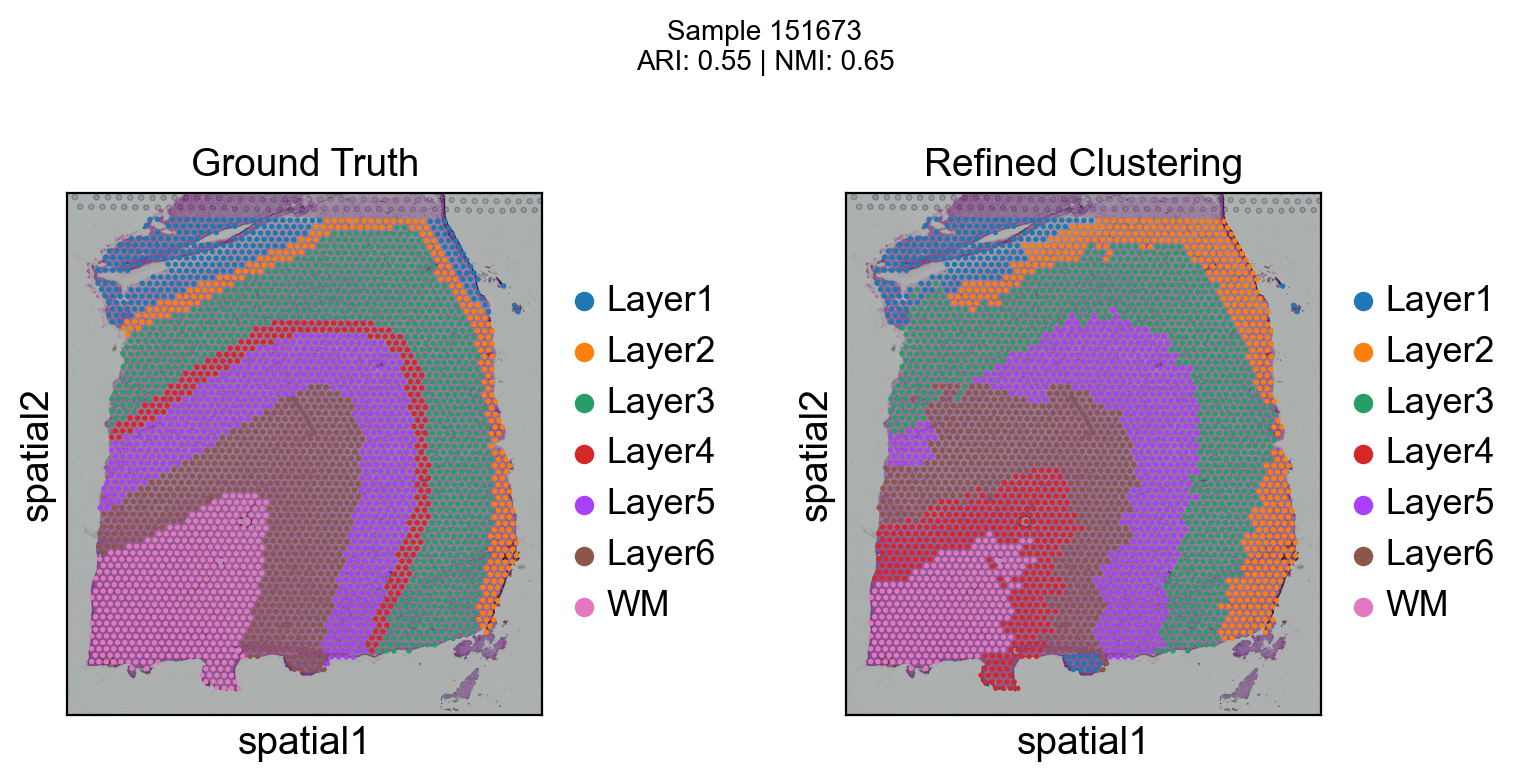

✅ Saved plot to: C:\Users\assali.i\Desktop\jspca-project\tutorial\..\results\Multislice\Hungarian_Matched\jsPCA_joint_151673_matched_refined_comparison.png

📌 Plotting: jsPCA_joint_151674_matched


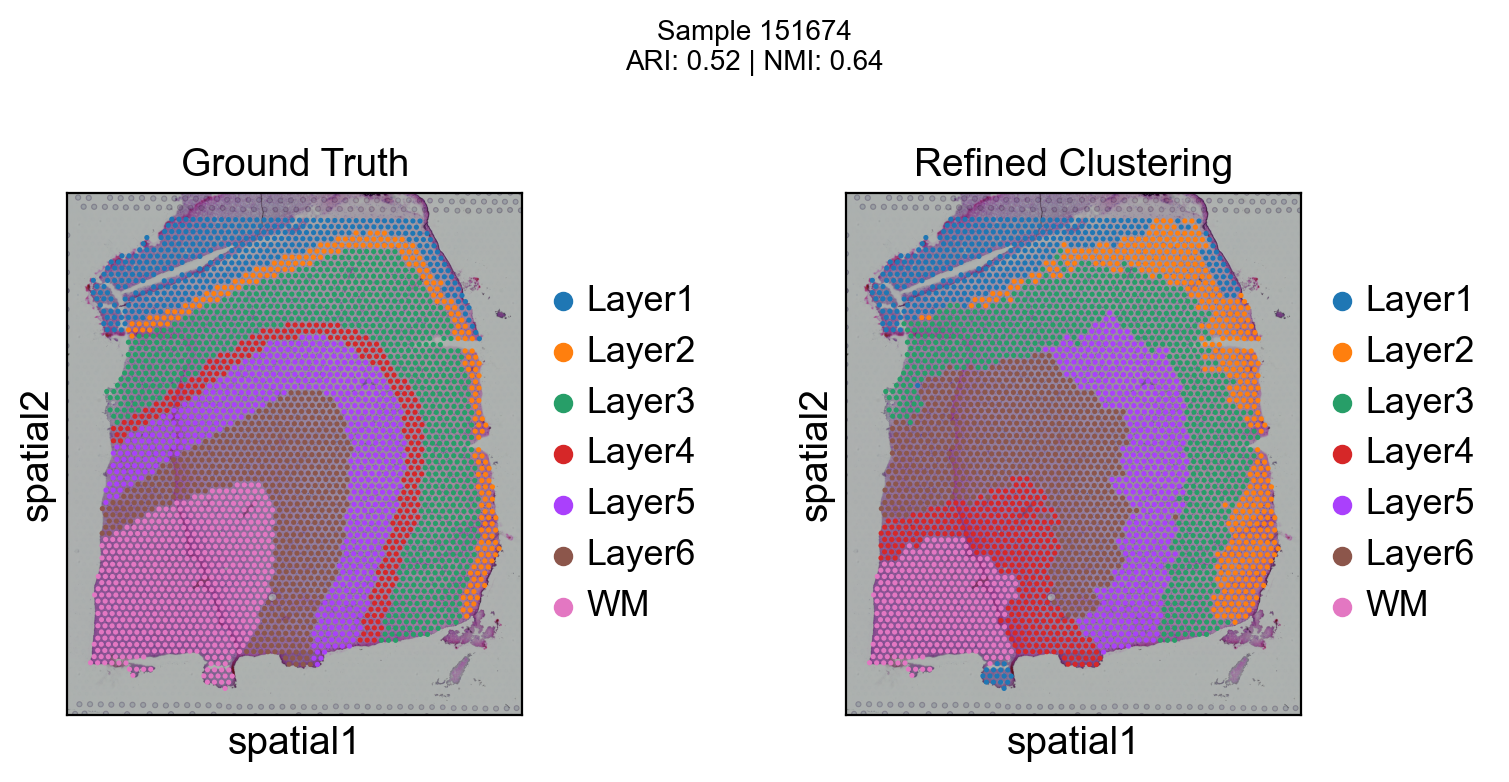

✅ Saved plot to: C:\Users\assali.i\Desktop\jspca-project\tutorial\..\results\Multislice\Hungarian_Matched\jsPCA_joint_151674_matched_refined_comparison.png


In [71]:
# -------------------------------
# Step 1️⃣ – Display settings
# -------------------------------
plot_folder = os.path.join(output_folder, "Hungarian_Matched")  # Folder with matched results
sc.set_figure_params(dpi=100)
plt.rcParams["figure.figsize"] = (8, 4)

# -------------------------------
# Step 2️⃣ – List of matched files to plot
# -------------------------------
file_list = glob.glob(os.path.join(plot_folder, "*_matched.h5ad"))

if not file_list:
    print("⚠️ No matched .h5ad files found. Run the Hungarian alignment step first.")
else:
    print(f"✅ Found {len(file_list)} matched files to plot:")
    for f in file_list:
        print("  •", os.path.basename(f))

# Sort files numerically by sample ID (optional, for consistent order)
def extract_numeric_id(path):
    filename = os.path.basename(path)
    digits = ''.join(filter(str.isdigit, filename))
    return int(digits) if digits else 0

file_list = sorted(file_list, key=extract_numeric_id)

# -------------------------------
# Step 3️⃣ – Loop over files and plot
# -------------------------------
for file_path in file_list:
    basename = os.path.basename(file_path)
    sample_id = basename.replace("jsPCA_joint_", "").replace("_matched.h5ad", "")
    file_name = basename.replace(".h5ad", "")
    plot_title = f"Sample {sample_id}"

    print(f"\n📌 Plotting: {file_name}")

    # Load dataset
    adata = ad.read_h5ad(file_path)

    # Check required columns
    if 'ground_truth' not in adata.obs or 'refined_pred_Hungarian' not in adata.obs:
        print(f"⚠️ Skipping {file_name}: missing 'ground_truth' or 'refined_pred_Hungarian'.")
        continue

    # Retrieve previously computed ARI/NMI and round to 2 decimals
    ari = adata.uns.get("ARI", None)
    nmi = adata.uns.get("NMI", None)
    if ari is not None:
        ari = round(ari, 2)
    if nmi is not None:
        nmi = round(nmi, 2)

    # Full figure title
    full_title = f"{plot_title}"
    if ari is not None and nmi is not None:
        full_title += f"\nARI: {ari} | NMI: {nmi}"

    # Create side-by-side plots
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    fig.suptitle(full_title, fontsize=10)

    # 🧭 Plot 1: Ground Truth
    sc.pl.spatial(
        adata,
        color="ground_truth",
        spot_size=100,
        ax=axs[0],
        show=False,
        title="Ground Truth"
    )

    # 🧬 Plot 2: Refined Clustering (Hungarian-aligned)
    sc.pl.spatial(
        adata,
        color="refined_pred_Hungarian",
        spot_size=100,
        ax=axs[1],
        show=False,
        title="Refined Clustering"
    )

    # Save figure
    plot_path = os.path.join(plot_folder, f"{file_name}_refined_comparison.png")
    plt.tight_layout()
    plt.savefig(plot_path, dpi=150)
    plt.show()
    plt.close()

    print(f"✅ Saved plot to: {plot_path}")
